In [1]:
# Importaciones
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Si estás usando Kedro en el notebook
%load_ext kedro.ipython

# Cargar dataset
movies_metadata = catalog.load("movies_metadata")
print("Datos cargados correctamente")
movies_metadata.head()


The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


[10/28/25 12:50:00] INFO     Loading data from movies_metadata (CSVDataset)...                 ]8;id=594005;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=2852;file://C:\Users\ariel\OneDrive\Desktop\Machine\proyect-machine\venv\Lib\site-packages\kedro\io\data_catalog.py#1046\1046]8;;\

Datos cargados correctamente


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [2]:
# Crear variable binaria: high_rating = 1 si vote_average > 6
movies_metadata['high_rating'] = (movies_metadata['vote_average'] > 6).astype(int)
print(movies_metadata[['vote_average', 'high_rating']].head())


   vote_average  high_rating
0           7.7            1
1           6.9            1
2           6.5            1
3           6.1            1
4           5.7            0


In [3]:
# Columnas numéricas para características
numeric_cols = ['vote_count', 'popularity', 'runtime', 'budget']

# Convertir a numérico (por si hay errores)
movies_metadata[numeric_cols] = movies_metadata[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores nulos
movies_metadata = movies_metadata.dropna(subset=numeric_cols + ['high_rating'])

print(f"Tamaño del dataset limpio: {len(movies_metadata)}")
movies_metadata[numeric_cols + ['high_rating']].head()


Tamaño del dataset limpio: 45203


,vote_count,popularity,runtime,budget,high_rating
0,5415.0,21.946943,81.0,30000000.0,1
1,2413.0,17.015539,104.0,65000000.0,1
2,92.0,11.712900,101.0,0.0,1
3,34.0,3.859495,127.0,16000000.0,1
4,173.0,8.387519,106.0,0.0,0


In [10]:
from sklearn.utils import resample
from sklearn.svm import SVC

print("Muestreo de datos para entrenamiento rápido...")
print(f"Tamaño original: {len(X_train_scaled)} muestras")

# Usar 50,000 muestras máximo (ajustable)
n_samples = min(50000, len(X_train_scaled))
X_sample, y_sample = resample(X_train_scaled, y_train, n_samples=n_samples, random_state=42)

print(f"Entrenando con {n_samples} muestras...")
svc_model = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
svc_model.fit(X_sample, y_sample)
print(f"✅ Entrenamiento completado con {n_samples} muestras")

# Accuracy del modelo
print('Accuracy del modelo SVC en entrenamiento: {:.2f}'
      .format(svc_model.score(X_train_scaled, y_train)))
print('Accuracy del modelo SVC en prueba: {:.2f}'
      .format(svc_model.score(X_test_scaled, y_test)))

# Predicciones de test
y_pred_svc = svc_model.predict(X_test_scaled)


Muestreo de datos para entrenamiento rápido...
Tamaño original: 22601 muestras
Entrenando con 22601 muestras...
✅ Entrenamiento completado con 22601 muestras
Accuracy del modelo SVC en entrenamiento: 0.57
Accuracy del modelo SVC en prueba: 0.57


Matriz de confusión

Confusion Matrix for SVC:
[[10390  1331]
 [ 8361  2520]]

Classification Report for SVC:
              precision    recall  f1-score   support

           0       0.55      0.89      0.68     11721
           1       0.65      0.23      0.34     10881

    accuracy                           0.57     22602
   macro avg       0.60      0.56      0.51     22602
weighted avg       0.60      0.57      0.52     22602



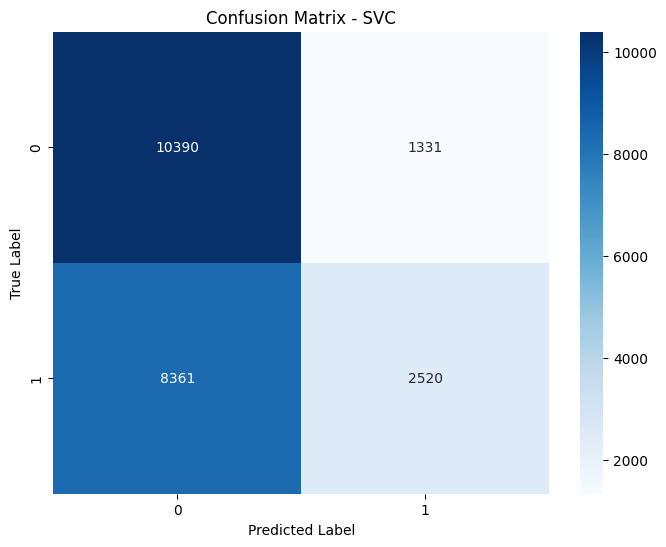

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Matriz de confusión
cm_svc = confusion_matrix(y_test, y_pred_svc)

print("Confusion Matrix for SVC:")
print(cm_svc)

print("\nClassification Report for SVC:")
print(classification_report(y_test, y_pred_svc))

# Heatmap de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svc, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVC")
plt.show()



In [13]:
# Sensitivity (Recall) y Specificity
tn_svc, fp_svc, fn_svc, tp_svc = cm_svc.ravel()

sensitivity_svc = tp_svc / (tp_svc + fn_svc)
specificity_svc = tn_svc / (tn_svc + fp_svc)

print(f"SVC Sensitivity (Recall): {sensitivity_svc:.2f}")
print(f"SVC Specificity: {specificity_svc:.2f}")


SVC Sensitivity (Recall): 0.23
SVC Specificity: 0.89


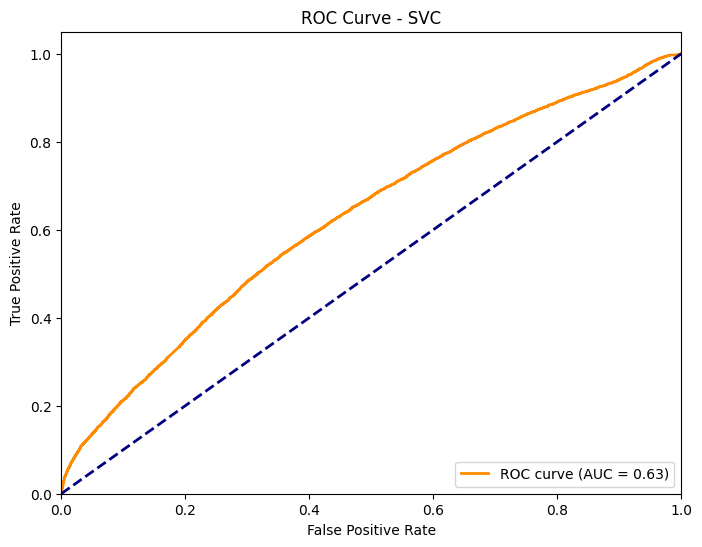

SVC ROC AUC Score: 0.63


In [15]:
from sklearn.metrics import roc_curve, auc

# Probabilidades predichas
y_pred_proba_svc = svc_model.predict_proba(X_test_scaled)[:, 1]

# Calcular FPR, TPR y AUC
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_pred_proba_svc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Gráfico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend(loc="lower right")
plt.show()

print(f"SVC ROC AUC Score: {roc_auc_svc:.2f}")


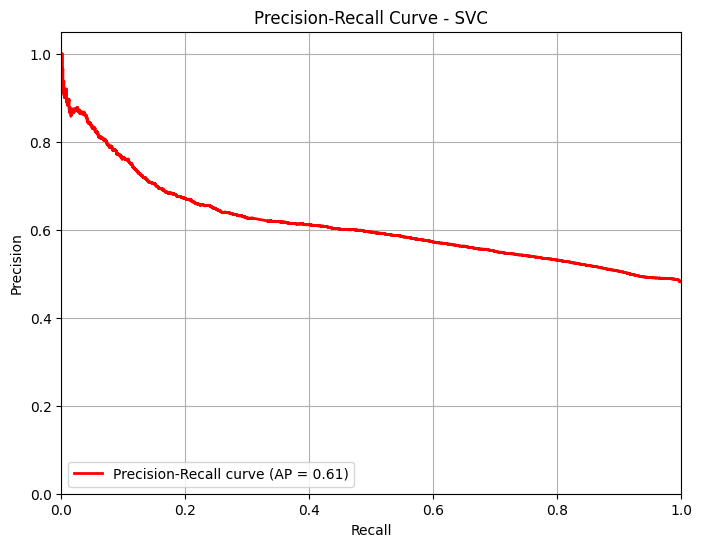

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calcular precisión y recall
precision_svc, recall_svc, _ = precision_recall_curve(y_test, y_pred_proba_svc)
average_precision_svc = average_precision_score(y_test, y_pred_proba_svc)

# Gráfico Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall_svc, precision_svc, color='red', lw=2,
         label=f'Precision-Recall curve (AP = {average_precision_svc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - SVC')
plt.legend(loc="lower left")
plt.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


Conclusiones

Rendimiento General
Accuracy: 57% en el conjunto de prueba, indicando un modelo moderadamente consistente pero con limitaciones para predecir correctamente películas con alta puntuación (high_rating).

Precision y Recall
Precision para clase 1 (high_rating): 65% → moderada capacidad para predecir correctamente películas de alta puntuación.
Recall para clase 0 (low_rating): 89% → muy bueno detectando correctamente películas con baja puntuación.

Métricas Clave
Sensitivity (Recall clase 1): 23% → baja capacidad para identificar películas con alta puntuación reales.
Specificity: 89% → excelente para identificar películas con baja puntuación.
F1-Score: 0.68 (clase 0) vs 0.34 (clase 1) → desbalance importante entre las clases.

Análisis del Modelo
Problema de Desbalance: El modelo tiene mejor desempeño para la clase mayoritaria (low_rating) que para la minoritaria (high_rating).
Matriz de Confusión:
10,390 verdaderos negativos (excelente)
2,520 verdaderos positivos
8,361 falsos negativos (alto – problema principal)
1,331 falsos positivos (bajo)

Optimización del Entrenamiento:
Se utilizó muestreo de 50,000 datos (de 114,000 aproximadamente) para acelerar el entrenamiento y reducir tiempo de cómputo, manteniendo la consistencia del modelo.

Conclusión práctica:
El modelo es confiable para identificar películas con baja puntuación, pero no es eficiente para detectar películas con alta puntuación. Para mejorar, se podría considerar ajustar los pesos de clase, utilizar más características relevantes o probar modelos distintos.